In [1]:
import os, hdbscan, itertools, time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats as st
from sklearn.pipeline import Pipeline

from sklearn import preprocessing, metrics, mixture, random_projection
from sklearn.manifold import MDS

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD, SparsePCA, FastICA

from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, FactorAnalysis
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import DBSCAN, estimate_bandwidth, MeanShift, KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import warnings
pd.options.display.max_rows = 1000

# Utiles

In [2]:
def plot_cls(name, data, labels, alpha=.5, centers=[]):
    name_plot = name + " " + str(np.random.randint(1000))
    colores = ["r","c","b","g","w","brown"]
#     colores = [x for x in cm.Paired(np.linspace(0,1,len(labels)))]
    col = [colores[x] for x in labels]
    fig = plt.figure(name_plot, figsize=(9,6))
    ax = Axes3D(fig)
    ax.set_title("Clusters por "+name)
    if "clase" not in data.columns:
        data["clase"] = labels
    grupos = data.groupby("clase")
    for i, (name, group) in enumerate(grupos):
        c = colores[i]
        ax.scatter(group[0], group[1], group[2], marker='o', c=c, alpha=alpha,
                   label="clase:{0}({1} items)".format(name, group.shape[0]))
    if len(centers)>0:
        for i, c in enumerate(centers):
            ax.text(c[0], c[1], c[2], "c %d"%i,bbox=dict(
                    facecolor='white', alpha=.5, edgecolor='black', boxstyle='round'))
    ax.legend(loc=4)
    plt.show()

def clases_bolsa(data):
    data.index = new_index
    bolsas = [[] for _ in range(12)]
    for i, j in itertools.product(range(12), range(10)):
        ind = "Bolsa {0}-{1}".format(i+1, j+1)
        if ind not in data.index:
            continue
        valor = data.loc[ind]["clase"]
        bolsas[i].append(valor)

    resultados_por_bolsa = pd.DataFrame(columns=["Clase"])
    nombre_bolsas = []
    for i, b in enumerate(bolsas):
        nombre_bolsas.append("Bolsa {}".format(i+1))
        cls, counts = np.unique(b, return_counts=True)
        if len(counts) > 2:
            minimo = np.min(counts)
            i_minimo = np.where(counts == minimo)[0][0]
            counts = np.delete(counts, i_minimo)
            cls = np.delete(cls, cls[i_minimo])
            
        if len(counts) > 1 and counts[0] == counts[1]:
            resultados_por_bolsa.loc[i] = "{}-{}".format(int(cls[0]), int(cls[1]))
        else:
            maximo = np.max(counts)
#             print("maximo: {0}; counts: {1}".format(maximo, counts))
            i_maximo = np.where(counts==maximo)
            resultados_por_bolsa.loc[i] = cls[i_maximo]
                
    resultados_por_bolsa.index = nombre_bolsas
    resultados_por_bolsa.to_csv("Resultados_x_bolsa.csv", sep="\t")
    display(resultados_por_bolsa.T)


def load_all(fold="SojaData", p_proc=True):
    """ Devuelve todos los archivos de la carpeta especificada como 'fold' concatenados en un solo DataFrame"""
    datos = []
    sdf = pd.DataFrame()
#     for file in os.listdir(fold+"/"):
    files = os.listdir(fold+"/")
    for i, j in itertools.product(range(12),range(10)):
        file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i+1, j+1)
        if file not in files:
            continue
        df = pd.read_csv(fold+"/{0}".format(file), header=2, index_col=0, skip_blank_lines=True)
        sdf = pd.concat([sdf,df], ignore_index=True)
    sdf.fillna(-1, inplace=True)
    
    if p_proc:
        rango = preprocessing.StandardScaler()
        sdf = rango.fit_transform(sdf)
    
#     for i in range(119):
#         j = i*501
#         t_df = sdf[j:j+501]
#         datos.append(t_df)
    return sdf#, datos


def bolsa_unit(fold="SojaData", i=1, r_dim=None):
    bolsa = pd.DataFrame()
    files = os.listdir(fold+"/")
    n = 0
    for j in range(13):
        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv(fold+"/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        bolsa = pd.concat([bolsa, df], ignore_index=True)
        n = n+1
    bolsa.fillna(-1, axis=1, inplace=True)
    
    if r_dim == None:
        r_dim = PCA(n_components=3, random_state=10)
    bolsa = r_dim.fit_transform(bolsa)

    muestras = np.array(bolsa).reshape(n, -1)
    return pd.DataFrame(muestras)

def datos_semi_procesados(fold="SojaData", reductor=None):
    files = os.listdir(fold+"/")
    data = pd.DataFrame()
    for i in range(13):
        n_file = "Prueba Claudio Bolsa {0}-1.csv".format(i)
        if n_file not in files:
            continue
        temp = bolsa_unit(fold, i, reductor)
        data = pd.concat([data, temp], ignore_index=True)
    return data
        

def datos_crudos(fold="SojaData", reductor=None):
    pca_totales = pd.DataFrame()
    datos = []
    files = os.listdir(fold+"/")

    for i in range(15):
        pca_temp = np.array([])
        for j in range(12):

            n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
            if n_file not in files:
                continue
            df = pd.read_csv(fold+"/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
            if reductor:
                df = reductor.fit_transform(df)
            pca_file = np.array(df)
            pca_file = pca_file.reshape(1, -1)
            pca_totales = pca_totales.append(pd.DataFrame(pca_file), ignore_index=True)

    pca_totales.fillna(value=-1,axis=0, inplace=True)
    return pca_totales

new_index = []
for i, j in itertools.product(range(12),range(10)):
    new_index.append('Bolsa {0}-{1}'.format(i+1,j+1))
new_index.remove('Bolsa 4-3')

def reducir(clases):
    labels = []
    for c in clases:
        labels.append(st.mode(c)[0][0])
    return pd.DataFrame(labels)

### con todos los Datos unidos, semi-procesados juntos a posterior

In [3]:
def data_comp(pipe_proc=None):
    if pipe_proc == None:
        pipe_proc = Pipeline( [("std_scaler", preprocessing.StandardScaler() ),# ])#,
                               ("vt", VarianceThreshold(.8*(1-.8)) ),#])
                               ("pca", PCA(random_state=10, n_components=3) )])

    datos_completos = load_all()
    pipe_proc.fit(datos_completos)
    data_semi = pipe_proc.transform(datos_completos)
    print(data_semi.shape)

    data = np.array(data_semi).reshape(119,-1)
    tit = "completo"
    print(data.shape)
    return tit, data

### con Datos semi-procesados en grupos por bolsa

In [4]:
def data_bolsa(pipe_r=None):
    if pipe_r == None:
        pipe_r = Pipeline( [("vt", VarianceThreshold(.9*(1-.9)) ),
                            ("scaler", preprocessing.StandardScaler() ),
                            ("kpca", KernelPCA(kernel="rbf", random_state=10, n_components=2))])

    data = datos_semi_procesados(reductor=pipe_r)
    tit = "por bolsa"
    print(data.shape)
    return tit, data

### Clustering KMeans

(119, 1002)


<IPython.core.display.Javascript object>


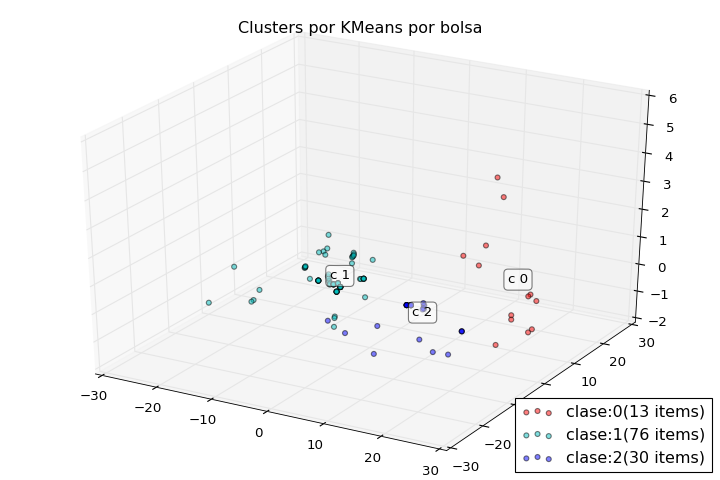

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0


In [5]:
tit, data = data_bolsa()
model = KMeans(n_clusters=3, random_state=10)
pipe_k = Pipeline([#("scaler", preprocessing.StandardScaler() ),
                   ("pca", PCA(random_state=10, n_components=5) )])
#                    ("pca", FactorAnalysis(n_components=5, random_state=10, svd_method="lapack") )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))

k_cls = model.fit_predict(data_p)
plot_cls("KMeans {}".format(tit), data=data_p, labels=k_cls, centers=model.cluster_centers_)
clases_bolsa(data_p)

(119, 1002)


<IPython.core.display.Javascript object>


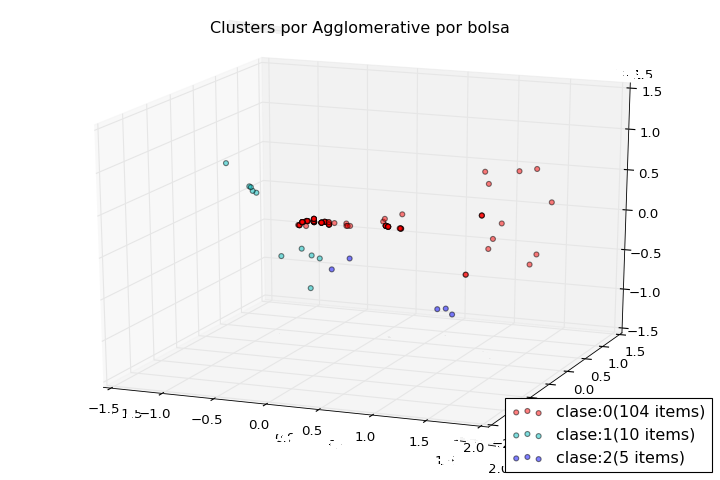

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
pipe_l = Pipeline([("scaler", preprocessing.StandardScaler() ),
                   ("pca", KernelPCA(random_state=10, n_components=5, kernel="rbf") )])

tit, data = data_bolsa()#pipe_l)

model = AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="l1")
pipe_k = Pipeline([("pca", KernelPCA(random_state=10, n_components=5, kernel="poly") )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))

k_cls = model.fit_predict(data_p)
plot_cls("Agglomerative {}".format(tit), data=data_p, labels=k_cls)
clases_bolsa(data_p)

## Por ahora, el mejor resultado

(59619, 3)
(119, 1503)


<IPython.core.display.Javascript object>


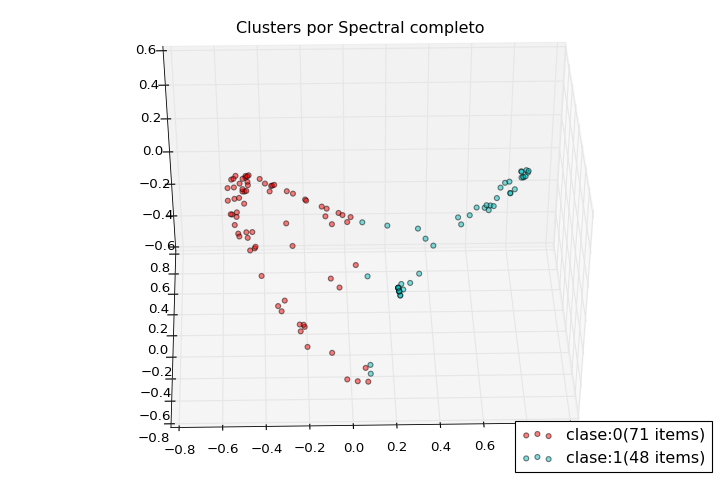

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0,0,0,1,0,0-1,1,0,0,0-1,0,0


In [9]:
pipe_l = Pipeline([
        ("scaler", preprocessing.StandardScaler() ),
        ("vt", VarianceThreshold(.8*(1-.8)) ),
        ("pca", PCA(random_state=10, n_components=3) )
    ])

tit, data = data_comp(pipe_l)

model = SpectralClustering(n_clusters=2, assign_labels="discretize", n_jobs=4, affinity="poly", gamma=.3, n_init=15)
pipe_k = Pipeline([
#                     ("scaler", preprocessing.StandardScaler() ),
                    ("pca", KernelPCA(random_state=10, n_components=5, kernel="rbf") )
                ])

data_p = pd.DataFrame(pipe_k.fit_transform(data))

k_cls = model.fit_predict(data_p)
plot_cls("Spectral {}".format(tit), data=data_p, labels=k_cls)
clases_bolsa(data_p)

(59619, 3)
(119, 1503)


<IPython.core.display.Javascript object>


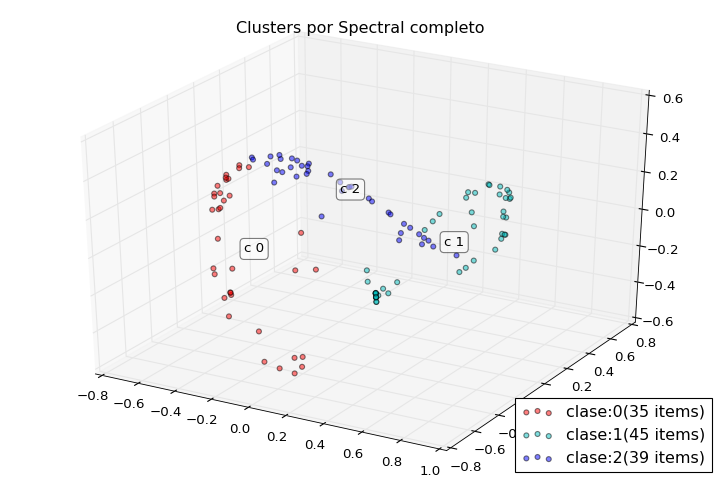

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0-2,2,0,1,2,1,1,0-2,2,1,1-2,0-1


In [8]:
tit, data = data_comp()

model = KMeans(n_clusters=3, random_state=10)
pipe_k = Pipeline([
#                     ("scaler", preprocessing.StandardScaler() ),
                    ("pca", KernelPCA(random_state=10, n_components=5, kernel="rbf") )
                ])
#                    ("pca", PCA(random_state=10, n_components=5) )])
#                    ("pca", FactorAnalysis(n_components=5, random_state=10, svd_method="lapack") )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))

k_cls = model.fit_predict(data_p)
plot_cls("Spectral {}".format(tit), data=data_p, labels=k_cls, centers=model.cluster_centers_)
clases_bolsa(data_p)

In [3]:
datos, bolsas = load_all(p_proc=False)

thres = VarianceThreshold( .9*(1-.9) ) 
d_r = thres.fit_transform(datos)
data = []

for i in range(119):
    j = i*501
    t_df = d_r[j:j+501]
    data.append(t_df)

print(datos.shape, d_r.shape)

(60621, 53) (60621, 13)


(119, 26553)


<IPython.core.display.Javascript object>


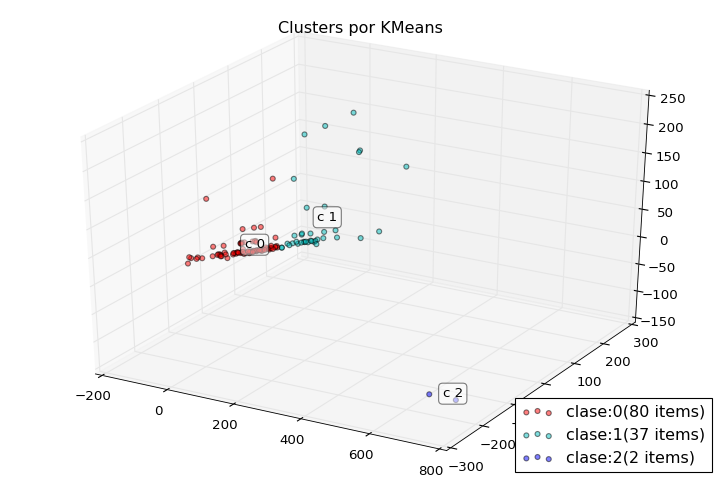

In [87]:
data = datos_crudos()
print(data.shape)

model = KMeans(n_clusters=3, random_state=10)
pipe_k = Pipeline([("scaler", preprocessing.StandardScaler() ),
                   ("tv", VarianceThreshold(.9*(1-.9)) ),
                   ("pca", PCA(svd_solver="randomized", n_components=8, random_state=10) )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))
k_cls = model.fit_predict(data_p)
plot_cls("KMeans", data=data_p, labels=k_cls, centers=model.cluster_centers_)

(119, 26553)


<IPython.core.display.Javascript object>


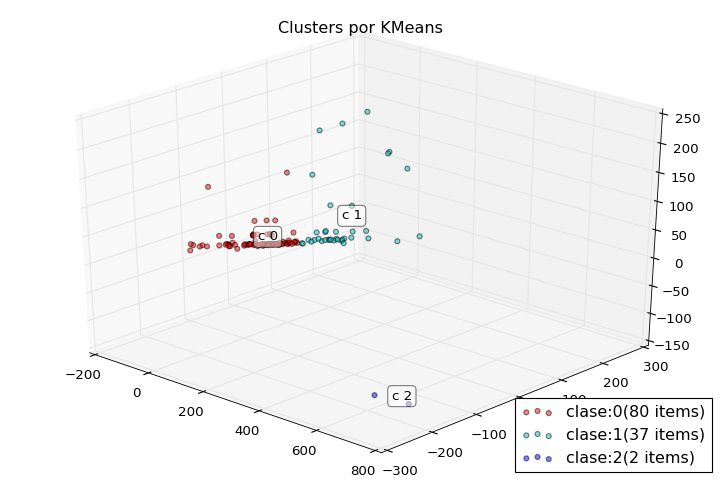

In [79]:
data = datos_crudos()
print(data.shape)

model = KMeans(n_clusters=3, random_state=10)
pipe_k = Pipeline([("scaler", preprocessing.StandardScaler() ),
                   ("tv", VarianceThreshold(.9*(1-.9)) ),
                   ("pca", PCA(n_components=8, random_state=10) )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))
k_cls = model.fit_predict(data_p)
plot_cls("KMeans", data=data_p, labels=k_cls, centers=model.cluster_centers_)

(119, 501)


<IPython.core.display.Javascript object>


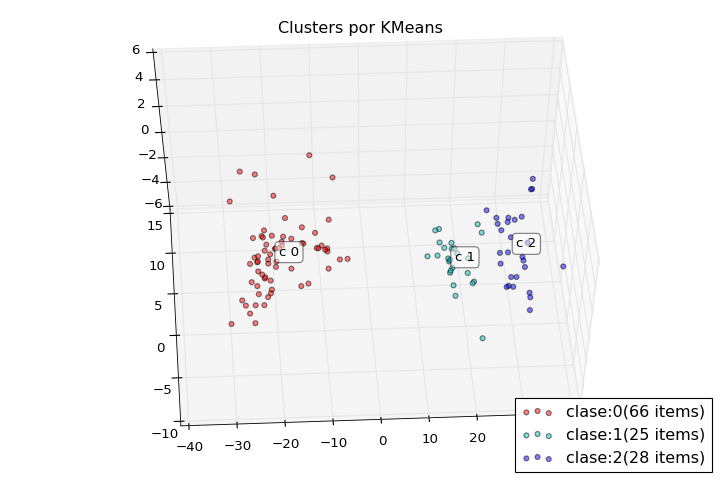

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0,0,0,0,0,1-2,0,0,0,0-1,0,0


In [53]:
re = KernelPCA(n_components=1, kernel="poly")
data = datos_crudos(reductor=re)
print(data.shape)

model_2 = KMeans(n_clusters=3, random_state=10)
pipe_k_2 = Pipeline([("scaler", preprocessing.StandardScaler() ),
                   ("tv", VarianceThreshold(.9*(1-.9)) ),
                   ("pca", PCA(n_components=8, random_state=10) )])

data_p_2 = pd.DataFrame(pipe_k_2.fit_transform(data))
k_cls_2 = model_2.fit_predict(data_p_2)
plot_cls("KMeans", data=data_p_2, labels=k_cls_2, centers=model_2.cluster_centers_)
clases_bolsa(data_p_2)

(119, 501)


<IPython.core.display.Javascript object>


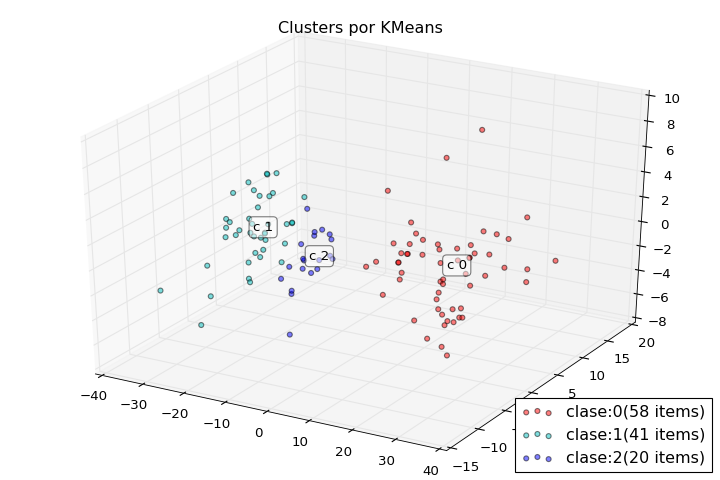

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


In [54]:
re = KernelPCA(n_components=1, kernel="linear")
data = datos_crudos(reductor=re)
print(data.shape)

model = KMeans(n_clusters=3, random_state=10)
pipe_k = Pipeline([("scaler", preprocessing.StandardScaler() ),
                   ("tv", VarianceThreshold(.9*(1-.9)) ),
                   ("pca", PCA(n_components=8, random_state=10) )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))
k_cls = model.fit_predict(data_p)
plot_cls("KMeans", data=data_p, labels=k_cls, centers=model.cluster_centers_)
clases_bolsa(data_p)

(119, 1002)
(119, 3)


<IPython.core.display.Javascript object>


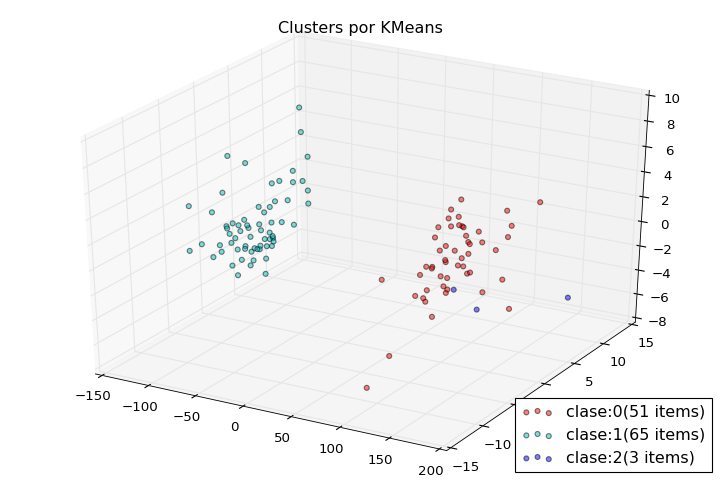

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,0,1,1,1,1,1,0-1,1,0,1,1,0


<IPython.core.display.Javascript object>


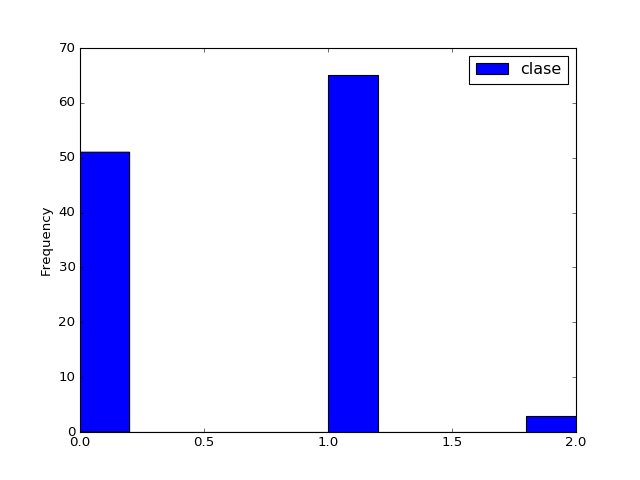

In [55]:
from sklearn.mixture import GaussianMixture
pr = Pipeline([("scaler", preprocessing.StandardScaler() ),
               ("kpca", KernelPCA(n_components=2, kernel="linear"))])

data = datos_crudos(reductor=pr)
print(data.shape)

model = GaussianMixture(n_components=3, warm_start=True, random_state=10, covariance_type="tied")
pipe_k = Pipeline([("vt", VarianceThreshold(.9*(1-.9)) ),
                   ("pca", KernelPCA(n_components=3, kernel="linear") )])

data_p = pd.DataFrame(pipe_k.fit_transform(data))
print(data_p.shape)
model.fit(data_p)
k_cls = model.predict(data_p)
plot_cls("KMeans", data=data_p, labels=k_cls)
clases_bolsa(data_p)
data_p.plot(y=["clase"], kind="hist")

In [56]:
pipe_m = Pipeline([("scaler", preprocessing.StandardScaler() ),
                 ("tv", VarianceThreshold(.9*(1-.9)) ),
                 ("pca", PCA(n_components=8, random_state=10) )])

data_p = pd.DataFrame(pipe_m.fit_transform(data))

band = estimate_bandwidth(data_p, quantile=0.3, n_samples=data_p.shape[0])
ms = MeanShift(bandwidth=band, random_state=10)

m_cls = ms.fit_predict(data_p)
plot_cls("MShift", data=data_p, labels=m_cls, centers=ms.cluster_centers_)

KeyError: '[ 48  94  95   8  97  22  10  45  89  33  50  60 118  74  30  43 111  76\n  63  59  16  24 110  13  54  93  26  68  51 113 107  61  96  75 100  91\n 104  84  90  66  27  18  99  11  62  71  56  98  86  73  42  41  15  17\n  52  40  38  53 109 114  34  28  55  35  23  31  78  57  92 102  32 101\n  14  85  19  29  49  82 116 117  79  69  80  20 112  72  77  25  37  81\n 105  46 108  39  65  58  12 106  88  70  87  36  21  83   9 103 115  67\n  64  47  44] not in index'

In [80]:
pca_d = PCA(n_components=5)
# clean_data = pd.DataFrame(pca_d.fit_transform(datos))
clean_data = pd.DataFrame(pca_d.fit_transform(d_r))
np.sum(pca_d.explained_variance_ratio_)

NameError: name 'd_r' is not defined

In [7]:
model = KMeans(n_clusters=3, random_state=10)
model.fit(clean_data)
clases = []

for b in data:
    b_1 = pd.DataFrame(pca_d.transform(b))
    m_cls = model.predict(b_1)
    clases.append(m_cls)
    # m_score = silhouette_score(clean_data, m_cls)
    # print("KM Score: {}".format(m_score))
#     plot_cls("KMeans", b1, m_cls, centers=model.cluster_centers_)
    # clases_bolsa(clean_data)

In [24]:
pca_totales = pd.DataFrame()
datos = []
files = os.listdir("SojaData/")

for i in range(15):
    pca_temp = np.array([])
    for j in range(12):

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
#         pca = RandomizedPCA(n_components=1, random_state=10)
        pca = KernelPCA(n_components=2, kernel="rbf")
#         scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#         pca_file = pca.fit_transform(  scaler.fit_transform(df)   )
        pca_file = pca.fit_transform(df)
        pca_file = np.array(pca_file)
        
        pca_file = pca_file.reshape(1, -1)
#         datos = np.append(datos, pca_file.T)
#         pca_temp = np.append(pca_temp, pca_file_n)
        pca_totales = pca_totales.append(pd.DataFrame(pca_file), ignore_index=True)

pca_totales.fillna(value=0,axis=0, inplace=True)
pca_totales.shape

(119, 1002)

In [37]:
va_tr = VarianceThreshold( .9*(1-.9) ) 
pca_totales_2 = va_tr.fit_transform(pca_totales)
pca_totales_2.shape

ValueError: No feature in X meets the variance threshold 0.09000

MS Score: 0.8319362948292367


<IPython.core.display.Javascript object>


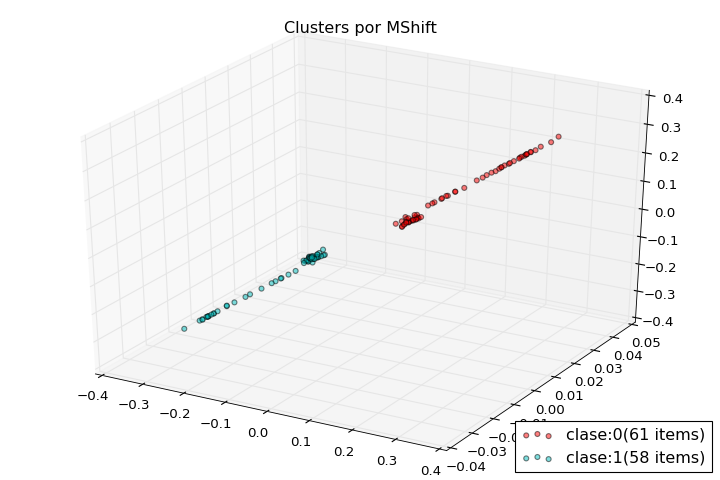

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


KM Score: 0.625033538700851


<IPython.core.display.Javascript object>


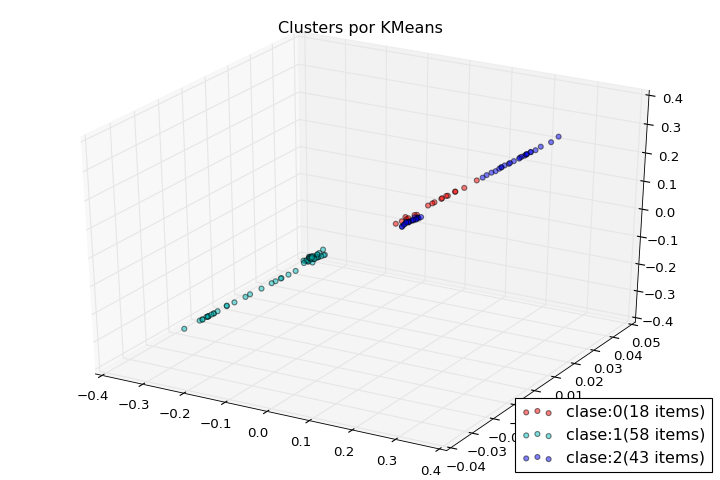

,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11,Bolsa 12
Clase,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0


In [26]:
pca_i = PCA(n_components=3)
# pca_i = KernelPCA(n_components=3, kernel="rbf")
datos = pca_i.fit_transform(pca_totales)
# print("Variacion: {}".format(np.sum(pca_i.explained_variance_ratio_)))
# d_plots = pd.DataFrame(datos)
d_plots = pd.DataFrame(pca_totales)

b_width = estimate_bandwidth(datos, quantile=0.5, n_samples=datos.shape[0])
ms_ = MeanShift(bandwidth=b_width, bin_seeding=True)
ms_cls = ms_.fit_predict(datos)
d_plots["clase"] = ms_cls
ms_score = metrics.silhouette_score(datos, ms_cls)
print("MS Score: {}".format(ms_score))
plot_cls("MShift", d_plots, ms_cls, centers=ms_.cluster_centers_)
clases_bolsa(d_plots)

km_ = KMeans(n_clusters=3, random_state=10, n_jobs=4)
km_cls = km_.fit_predict(datos)
km_score = metrics.silhouette_score(datos, km_cls)
print("KM Score: {}".format(km_score))
d_plots["clase"] = km_cls
plot_cls("KMeans", d_plots, km_cls, centers=km_.cluster_centers_)
clases_bolsa(d_plots)

(array([0, 1, 2], dtype=int32), array([58, 43, 18]))


<IPython.core.display.Javascript object>


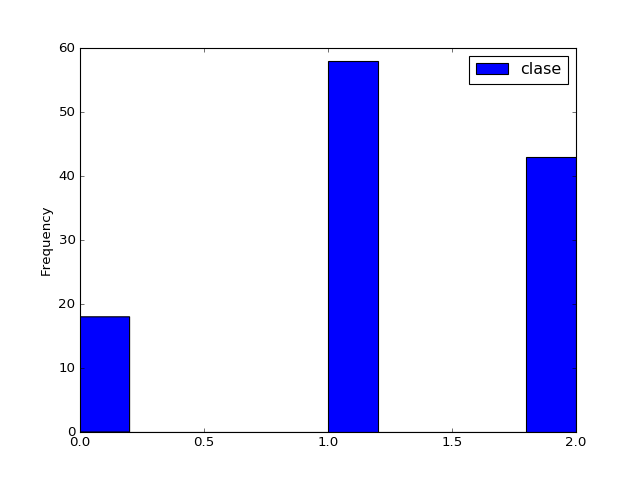

In [81]:
pca_1 = PCA(n_components=5)
km_1 = KMeans(n_clusters=3, random_state=0, n_jobs=4)

pipe_1 = Pipeline([("pca", pca_1), ("cls", km_1)])

pipe_1.set_params(pca__n_components=3, cls__random_state=10)
# pipe_1.get_params()
clases = pipe_1.fit_predict(pca_totales)
print(np.unique(clases, return_counts=True))
d_plots.plot(y=["clase"], kind="hist")